In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [107]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_jakarta'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-11-10 14:21:15,715: Credentials are already in use. The existing account in the session will be replaced.


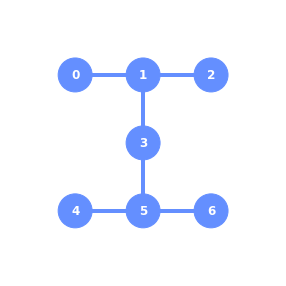

In [3]:
qubits = plot_gate_map(backend)
qubits

In [80]:
def extract_cr_params(cx_sched):
    cr_params = {}
    for time, inst in cx_sched.instructions:
        if isinstance(inst, Play):
            if isinstance(inst.pulse, GaussianSquare):
                if isinstance(inst.operands[1], ControlChannel):
                    cr_params["duration"] = inst.pulse.duration
                    cr_params["width"] = inst.pulse.width
                    cr_params["sigma"] = inst.pulse.sigma
                    cr_params["cr_amp"] = inst.pulse.amp
                    cr_params["channel"] = inst.channel
    return cr_params
                    

def build_cr_schedule(backend, qc, qt, cr_params, cr_name):
    
    with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
        pulse.play(GaussianSquare(
            duration=cr_params["duration"],
            amp=cr_params["cr_amp"],
            width=cr_params["width"],
            sigma=cr_params["sigma"],
            name=cr_name
        ),
        pulse.control_channels(qc, qt)[0],
    )
        if not np.isclose(cr_params["cancel_amp"], 0.0):
            pulse.play(GaussianSquare(
                duration=cr_params["duration"],
                amp=cr_params["cancel_amp"],
                width=cr_params["width"],
                sigma=cr_params["sigma"],
        ),
        pulse.drive_channel(qt),
    )
        else:
            pulse.delay(cr_params["duration"], pulse.drive_channel(qt))
        pulse.delay(cr_params["duration"], pulse.drive_channel(qc))
        
    return cross_resonance

def build_cr_circuit(gate):
    
    cr_circuit = QuantumCircuit(2)
    cr_circuit.append(gate, [0, 1])

    
    return cr_circuit

def build_amp_experiment_circuits(backend, qc, qt, amps, cr_params, rotary=False):
    
    circ_list = []
    
    inst_map_list = []
    for amplitude in amps:
        
        new_inst_map = deepcopy(inst_map)
    

        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[amplitude],
        )
        
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[-amplitude],
        )
        
        exp_circ = QuantumCircuit(2)

        ## add control state prep when needed
        
        
        exp_circ.rz(-np.pi/2, 0)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
#         exp_circ.x(0)
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }

        if rotary is True:
            cr_params['cancel_amp'] = amplitude
            
        cr_params["phi"] = 0
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))
        
        cr_params['phi'] = cr_params['phi'] + np.pi
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
#         new_inst_map.add('cr_gate', qubits=[qc, qt], schedule=build_cr_schedule(backend, qc, qt, cr_params))
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
    return circ_list, inst_map_list

def build_phase_experiment_circuits(backend, qc, qt, phases, cr_params, rotary=False):
    
    circ_list = []
    inst_map_list = []
    amp = cr_params['cr_amp']
    for phase in phases:
        new_inst_map = deepcopy(inst_map)
    
        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[phase],
        )
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[phase],
        )
        exp_circ = QuantumCircuit(2)
        exp_circ.rz(-np.pi/2, 0)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
        exp_circ.barrier(0, 1)
        exp_circ.sdg(1)
        exp_circ.h(1)
        
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }
        
        if rotary is True:
            cr_params['cancel_amp'] = cr_params["cr_amp"]
        
        cr_params['cr_amp'] = amp * np.exp(-1j*phase)
#         print(cr_params['cr_amp'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))

        phase = phase + np.pi
        cr_params['cr_amp'] = amp * np.exp(-1j*phase)
#         print(cr_params['cr_amp'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
        
    return circ_list, inst_map_list

def build_single_cr_circuit(backend, qc, qt, cr_params, rotary=False):
    amp = cr_params['cr_amp']
    cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[cr_params["cr_amp"], cr_params["phase"]],
        )
        
    cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[cr_params["cr_amp"], cr_params["phase"]],
        )
    exp_circ = QuantumCircuit(2)

        
    exp_circ.rz(-np.pi/2, 0)
    exp_circ.x(0)
    exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
    exp_circ.x(0)
    exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
    
    exp_circ.metadata={
        "qubits": (qc, qt)
    }

    if rotary is True:
        cr_params['cancel_amp'] = amplitude
        
    cr_params['cr_amp'] = amp * np.exp(-1j*cr_params["phase"])
    exp_circ.add_calibration(gate=cr_p_gate,
                            qubits=[qc,qt],
                            schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))

    cr_params['cr_amp'] = amp * np.exp(-1j*(cr_params["phase"]+np.pi))
    exp_circ.add_calibration(gate=cr_m_gate,
                            qubits=[qc,qt],
                            schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))  
    
    return exp_circ
    
        
def expectation_val(count_dict, mem_ind):

    expv = 0
    for key, val in count_dict.items():
        if key[::-1][mem_ind] == '1':
#             print(key, val)
            expv -= val
        else:
            expv += val
#     print(expv)
    return expv / sum(count_dict.values())

In [5]:
q1, q2 = 0, 1
mem_ind = 0 if q1 > q2 else 1

# IBM's cross resonance gate
This is what IBM's cross-resonance gate looks like - extracted from the CX pulse schedule, and with the rotary tones not shown.

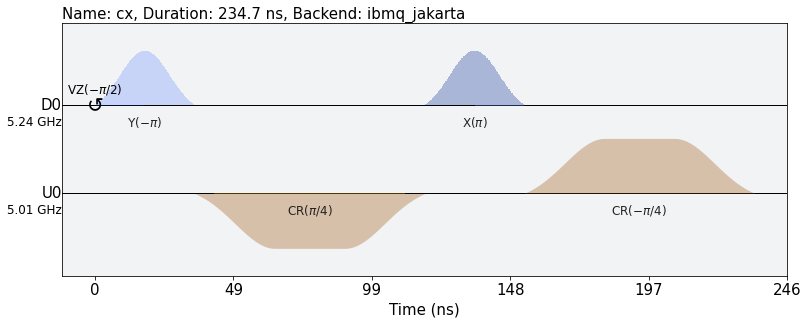

In [93]:
cx_sched = inst_map.get('cx', qubits=[q1, q2])
draw(cx_sched, backend=backend, disable_channels=[DriveChannel(q2)])

In [7]:
for time, inst in cx_sched.instructions:
    print(inst)

ShiftPhase(1.5707963267948966, DriveChannel(0))
ShiftPhase(1.5707963267948966, ControlChannel(1))
Play(Drag(duration=160, amp=(-3.644999882003519e-17-0.1984245517178945j), sigma=40, beta=-0.9829540157682223, name='Ym_d0'), DriveChannel(0), name='Ym_d0')
Play(Drag(duration=160, amp=(0.09599921320851101+0.0020938824069987425j), sigma=40, beta=-1.086177309605262, name='X90p_d1'), DriveChannel(1), name='X90p_d1')
Play(GaussianSquare(duration=368, amp=(0.11223042808642263+0.0022701128456869457j), sigma=64, width=112, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')
Play(GaussianSquare(duration=368, amp=(-0.008041427821612962-0.758593746090016j), sigma=64, width=112, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')
Play(Drag(duration=160, amp=(0.1984245517178945+0j), sigma=40, beta=-0.9829540157682223, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Play(GaussianSquare(duration=368, amp=(-0.11223042808642263-0.002270112845686932j), sigma=64, width=112, name='CR90m_d1_u0'), DriveC

In [8]:
cr_params = extract_cr_params(cx_sched)
cr_params["cancel_amp"] = 0.0
cr_params["phi"] = 0
# print(cr_params)

max_cr_amplitude = 1.0
num_amps = 70
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, num_amps)
# print(cr_amps)

In [9]:
exp_circuits, exp_inst_maps = build_amp_experiment_circuits(backend, q1, q2, cr_amps, cr_params)
# exp_circuits[19].draw()

In [10]:
tc = transpile(exp_circuits, backend, initial_layout=[q1, q2])
sched = schedule(tc, backend)
for time, inst in sched[4].instructions:
    print(inst)

ShiftPhase(1.5707963267949, DriveChannel(0))
ShiftPhase(1.5707963267949, ControlChannel(1))
Play(Drag(duration=160, amp=(0.1984245517178945+0j), sigma=40, beta=-0.9829540157682223, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Delay(368, DriveChannel(0))
Delay(368, DriveChannel(1))
Play(GaussianSquare(duration=368, amp=(-0.8840579710144928+0j), sigma=64, width=112, name='cr_p'), ControlChannel(0), name='cr_p')
Play(Drag(duration=160, amp=(0.1984245517178945+0j), sigma=40, beta=-0.9829540157682223, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Delay(368, DriveChannel(0))
Delay(368, DriveChannel(1))
Play(GaussianSquare(duration=368, amp=(0.8840579710144928+1.0826587644636022e-16j), sigma=64, width=112, name='cr_m'), ControlChannel(0), name='cr_m')
Acquire(22400, AcquireChannel(0), MemorySlot(0))
Acquire(22400, AcquireChannel(1), MemorySlot(1))
Play(GaussianSquare(duration=22400, amp=(-0.19482499002862397-0.016231859423571263j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name

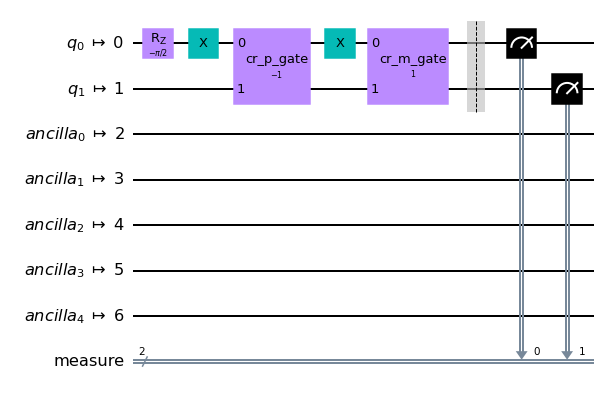

In [11]:
# tc[0].draw('mpl')

In [12]:
# draw(sched[4], backend=backend, time_range=[0, 1000], disable_channels=[MeasureChannel(q1), MeasureChannel(q2)])

In [13]:
i = 1
identifier = F"(({max_cr_amplitude}),{num_amps})"

In [14]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

618c03d7513c76539a62fee6


In [15]:
# 11/8/2021 - amplitude experiments
# ibm_lagos job (9:45~ am) - 6189380f1452777724117b88
# ibmq_jakarta job (10:00~ am) - 61893b88902694642fd98881
# ibmq_jakarta (10:30~ am) - 6189411bc45f2664c31517c5
# ibmq_jakarta (10:51~ am) - 61894761ad7fa029bcd1440f * best results so far (sweeping from (-1.0, 1.0, 70))
# ibmq_jakarta (11:23~ am) - 61894f14ad7fa0ed2ad14439
# ibmq_jakarta (12:47 pm) - 618962b8ce94116c106c071e (-1.0, 1.0, 70) - CRgate looks more like ibm
# ibmq_montreal (11:18~ am) - 61894de8c45f2661c61517fb
# ibmq_toronto (11:27~ am) - 61894fdab3f4906ac760bf9e
# ibmq_toronto (11:33~ am) - 61895180145277452e117c10

# 11/9/2021 - amplitude experiments
# ibmq_jakarta (10:33~ am) - 618a94942bf2b36efea11649 (-1.0, 1.0, 70)


# 11/10/2021 - amplitude experiments
# jakarta (12:40~ pm) - 618c03d7513c76539a62fee6
# job_id = "618962b8ce94116c106c071e"
results = backend.retrieve_job(job_id).result()


In [16]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 796, '01': 13, '10': 1223, '11': 16}, {'00': 811, '01': 20, '10': 1209, '11': 8}, {'00': 843, '01': 24, '10': 1166, '11': 15}, {'00': 880, '01': 19, '10': 1133, '11': 16}, {'00': 892, '01': 17, '10': 1127, '11': 12}, {'00': 949, '01': 30, '10': 1064, '11': 5}, {'00': 973, '01': 19, '10': 1047, '11': 9}, {'00': 980, '01': 9, '10': 1047, '11': 12}, {'00': 1042, '01': 14, '10': 979, '11': 13}, {'00': 1047, '01': 22, '10': 965, '11': 14}, {'00': 1079, '01': 21, '10': 937, '11': 11}, {'00': 1187, '01': 16, '10': 836, '11': 9}, {'00': 1184, '01': 18, '10': 836, '11': 10}, {'00': 1241, '01': 10, '10': 784, '11': 13}, {'00': 1307, '01': 25, '10': 712, '11': 4}, {'00': 1310, '01': 23, '10': 705, '11': 10}, {'00': 1335, '01': 24, '10': 685, '11': 4}, {'00': 1444, '01': 17, '10': 582, '11': 5}, {'00': 1455, '01': 21, '10': 569, '11': 3}, {'00': 1498, '01': 17, '10': 526, '11': 7}, {'00': 1541, '01': 23, '10': 476, '11': 8}, {'00': 1590, '01': 18, '10': 432, '11': 8}, {'00': 1651, '01': 27

In [17]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

In [18]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(count_dict[cind], mem_ind=mem_ind)
# print(exp_z)
valid_inds = np.where(np.abs(cr_amps) < 1.0)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

In [19]:
print(cr_pi2_amp)

0.7428954429353078


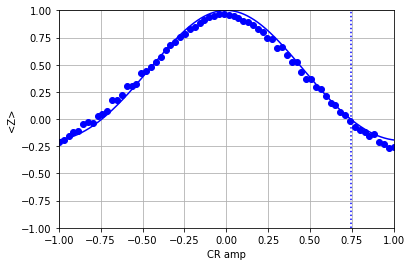

In [21]:
x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()
plt.savefig("amplitude_calibration_2")

In [22]:
cr_params = extract_cr_params(cx_sched)
cr_params["cr_amp"] = cr_pi2_amp
cr_params["cancel_amp"] = 0.0

max_phase = np.pi
num_phases = 20
cr_phases = np.linspace(-max_phase, max_phase, num_phases)


In [23]:
# for phase in cr_phases:
#     print(cr_pi2_amp * np.exp(-1j*phase))
#     print(cr_pi2_amp * np.exp(-1j*(phase+np.pi)))

In [24]:
print(cr_params)

{'duration': 368, 'width': 112, 'sigma': 64, 'cr_amp': 0.7428954429353078, 'channel': ControlChannel(0), 'cancel_amp': 0.0}


In [25]:
phase_exp_circuits, phase_exp_inst_maps = build_phase_experiment_circuits(backend, q1, q2, cr_phases, cr_params)


In [26]:
y0 = deepcopy(phase_exp_circuits)
y1 = []
for circ in y0:
    y1_circ = QuantumCircuit(2)
    y1_circ.x(0)
    y1_circ += circ
    y1.append(y1_circ)

<ipython-input-26-95e79d3478e8>:6: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  y1_circ += circ
C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


In [27]:
phase_exp_circuits = y0+y1
tc = transpile(phase_exp_circuits, backend, initial_layout=[q1, q2])
identifier = F"(({max_phase}),{num_phases})"

In [32]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

618c06763b109cdd2747751f


In [33]:
# 11/9/2021 - phase experiments
# ibmq_jakarta (11:27~ am) - 618aa15deb641130bbbb5c4f (-np.pi, np.pi, 20)

# 11/10/2021 - phase experiments
# jakarta (12:42~ pm) - 618c047e513c768d4d62feee (-np.pi, np.pi, 20) 
# job_id = "618c047e513c768d4d62feee"
results = backend.retrieve_job(job_id).result()
print(job_id)

618c047e513c768d4d62feee


In [34]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 1024, '01': 21, '10': 981, '11': 22}, {'00': 735, '01': 16, '10': 1279, '11': 18}, {'00': 439, '01': 11, '10': 1584, '11': 14}, {'00': 243, '01': 8, '10': 1773, '11': 24}, {'00': 97, '01': 14, '10': 1917, '11': 20}, {'00': 73, '01': 14, '10': 1944, '11': 17}, {'00': 135, '01': 8, '10': 1874, '11': 31}, {'00': 284, '01': 4, '10': 1737, '11': 23}, {'00': 507, '01': 14, '10': 1511, '11': 16}, {'00': 783, '01': 16, '10': 1234, '11': 15}, {'00': 1102, '01': 15, '10': 913, '11': 18}, {'00': 1370, '01': 21, '10': 641, '11': 16}, {'00': 1666, '01': 19, '10': 349, '11': 14}, {'00': 1877, '01': 12, '10': 149, '11': 10}, {'00': 1975, '01': 26, '10': 40, '11': 7}, {'00': 1969, '01': 25, '10': 45, '11': 9}, {'00': 1859, '01': 22, '10': 151, '11': 16}, {'00': 1633, '01': 28, '10': 374, '11': 13}, {'00': 1387, '01': 18, '10': 630, '11': 13}, {'00': 1024, '01': 16, '10': 989, '11': 19}, {'00': 38, '01': 880, '10': 55, '11': 1075}, {'00': 53, '01': 1129, '10': 29, '11': 837}, {'00': 74, '01': 1

In [35]:
print(len(count_dict))

40


In [36]:
def cos_fit_00(x, a, b):
    return a * np.cos(x - b + np.pi)

def cos_fit_10(x, a, b):
    return a * np.cos(x - b)

In [37]:
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

results_y0 = count_dict[:20]
results_y1 = count_dict[20:]

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(results_y0[cind], mem_ind=mem_ind)
    exp_y1[cind] = expectation_val(results_y1[cind], mem_ind=mem_ind)
# print(exp_y0)
# print(exp_y1)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2
print(phi_opt)

-1.4933937885388788


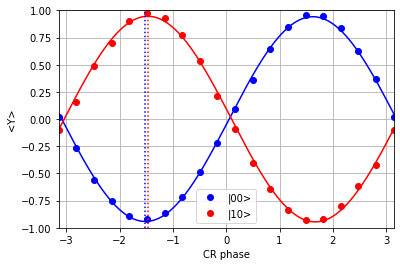

In [39]:
x_interp = np.linspace(cr_phases[0], cr_phases[-1], 1000)
plt.plot(cr_phases, exp_y0, 'o', color='b', label='|00>')
plt.plot(cr_phases, exp_y1, 'o', color='r', label='|10>')
plt.plot(x_interp, cos_fit_00(x_interp, *params0), 'b')
plt.plot(x_interp, cos_fit_10(x_interp, *params1), 'r')
plt.plot([params0[1], params0[1]], [-1, 1], 'b:')
plt.plot([params1[1], params1[1]], [-1, 1], 'r:')
plt.xlim(cr_phases[0], cr_phases[-1])
plt.ylim(-1, 1)
plt.xlabel('CR phase')
plt.ylabel('<Y>')
plt.grid()
plt.legend()
plt.savefig("phase_calibration_2")

In [96]:
cr_params = extract_cr_params(cx_sched)
cr_params["cr_amp"] = cr_pi2_amp
cr_params["cancel_amp"] = 0.0
cr_params["phase"] = phi_opt

In [97]:
cr_circ = build_single_cr_circuit(backend, q1, q2, cr_params, rotary=False)

In [122]:
my_cnot_circ = QuantumCircuit(2)
my_cnot_circ.x(0)
my_cnot_circ.x(1)
my_cnot_circ.compose(other=cr_circ, qubits=[0, 1], inplace=True)
my_cnot_circ.measure_active()

In [123]:
default_cnot = QuantumCircuit(2)
default_cnot.x(0)
default_cnot.cx(0, 1)
default_cnot.measure_active()

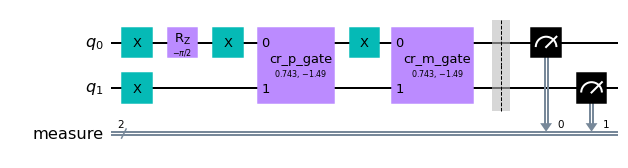

In [124]:
my_cnot_circ.draw('mpl')

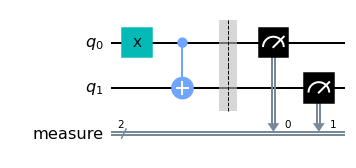

In [125]:
default_cnot.draw('mpl')

In [135]:
my_tc = transpile(my_cnot_circ, backend, initial_layout=[q1, q2])
default_tc = transpile(default_cnot, backend, initial_layout=[q1, q2])

circs = [my_tc]+[default_tc]


In [136]:
job = backend.run(circs, job_name=F"cnot_exp", shots=2048)
job_id = job.job_id()
print(job.job_id())

618c25b98b10e7814568d1c6


In [137]:
# 11/10/2021 cnot experiments
# jakarta (2:22~pm) - 618c1bb1513c764b2962ffaf --- messed up
# jakarta (2:51~pm) - 618c22d248856aacecedacb9 - ehhh
# jakarta (2:56~pm) - 618c23c83b109c3a24477641 -- messed up
# jakarta (3:04~pm) - 618c25b98b10e7814568d1c6 

results = backend.retrieve_job(job_id).result()
print(job_id)

618c25b98b10e7814568d1c6


In [138]:
counts = results.get_counts()
print(counts)

[{'00': 41, '01': 885, '10': 105, '11': 1017}, {'00': 52, '01': 92, '10': 95, '11': 1809}]


In [142]:
from qiskit.visualization import plot_histogram
plot_histogram(counts[0]).savefig("custom_cnot_simple")

In [143]:
plot_histogram(counts[1]).savefig("default_cnot_simple")

# QPT

In [68]:
import qiskit.ignis.verification.tomography
from qiskit import QuantumRegister
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
# Process tomography of a Hadamard gate
q = QuantumRegister(2)
circ = QuantumCircuit(q)
circ.swap(q[0], q[1])

# Generate process tomography circuits and run on qasm simulator
# We use the optional prepared_qubits kwarg to specify that the prepared qubit was different to measured qubit
qpt_circs = process_tomography_circuits(circ, q[1])

In [73]:
qpt_circs[10].draw()

░     ░                
q1904_0: ───────────░──X──░────────────────
         ┌───┐┌───┐ ░  │  ░ ┌─────┐┌───┐┌─┐
q1904_1: ┤ H ├┤ S ├─░──X──░─┤ Sdg ├┤ H ├┤M├
         └───┘└───┘ ░     ░ └─────┘└───┘└╥┘
   c3: 1/════════════════════════════════╩═
                                         0